# E03: Energy cascade in isotropic turbulence

We apply SURD on a real-world data set of the energy cascade in turbulence, which serves as a primary example of a chaotic, high-dimensional system. The cascade of energy in turbulent flows, namely, the transfer of kinetic energy from large to small flow scales or vice versa (backward cascade), has been the cornerstone of most theories and models of turbulence since the 1940s. Here, we investigate the redundant, unique, and synergistic causality of turbulent kinetic energy transfer across different scales. The case chosen to study the energy cascade is forced isotropic
turbulence in a triply periodic box with side $L$.  Data were obtained from a direct numerical simulation, where all flow scales are resolved, publicly available in https://torroja.dmt.upm.es/turbdata/.

In [1]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat
import pickle
import surd as surd
np.random.seed(10)

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

## Problem set-up

In [2]:
fname = '../data/energy_cascade_signals.mat'
data = loadmat(fname)
X = data['X']

nvars = X.shape[0]
nt = X.shape[1]
nbins = 10
nlag = 1

# Time
delta_t = 0.0076  # Time step (in units of Tε)
total_time = 165  # Total simulation time (in units of Tε)
time = np.arange(0, nt * delta_t, delta_t)

## Energy cascade signals

We used the transfer of kinetic energy across scales $\Sigma_i$, which served as a marker for the dynamics of the energy cascade. To obtain these signals, the velocity field was low-pass filtered at four filter widths:
$\bar{\Delta}_1=163 \eta$, $\bar{\Delta}_2=81\eta$,
$\bar{\Delta}_3=42\eta$, and $\bar{\Delta}_4=21\eta$.  The filter
widths are selected to represent four different flow scales and are located within the inertial range of the simulation:
$L_\varepsilon > \bar{\Delta}_i > \eta$, for $i=1,2,3$ and 4, where $L_\varepsilon$ represents the size of the largest scales and $\eta$ is the size of the smallest scales. Finally, we volume-averaged $\Sigma_i$ over the entire domain, denoted by
$\langle \Sigma_i \rangle$. The generated data are also resolved in time, with flow fields stored at intervals of $\Delta t
= 0.0076 T_\varepsilon$, where $T_\varepsilon$ is the characteristic time of the largest flow scales. The simulation was
intentionally run for an extended period to ensure the accurate
computation of specific mutual information. The total simulated time
after transient effects was equal to $165 T_\varepsilon$.

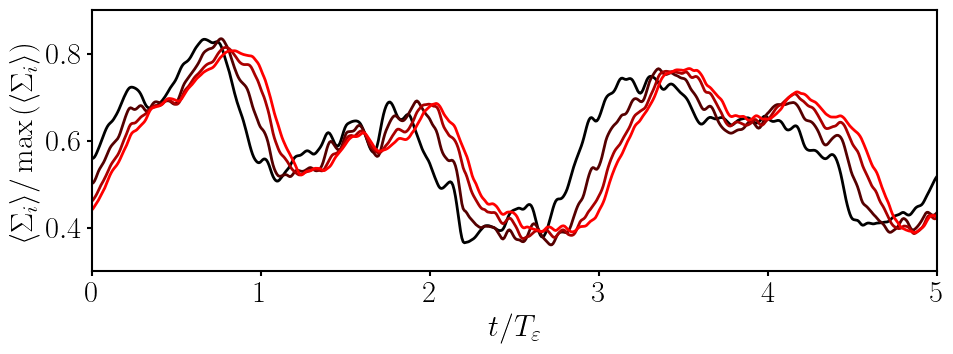

In [3]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Create a custom colormap from black to red
colors = [(0, 0, 0), (1, 0, 0)]  # Black to Red
n_bins = 4  # Increase this number for a smoother transition
cmap_name = 'my_black_red'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot each variable
for i in range(nvars):
    color = cm(i)  # Get color from colormap
    axs.plot(time,X[i, :], color=color, linewidth=2)

axs.set_xlim(0, 5)  # Set x-axis limits
axs.set_ylim(0.3, 0.9)  # Set x-axis limits
axs.set_ylabel(f'$\\langle\Sigma_i\\rangle / \\max\\left( \\langle\Sigma_i\\rangle \\right)$')
axs.set_xlabel(f'$t/T_\\varepsilon$')

# Adjust layout
plt.tight_layout()

# change all spines
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)

# increase tick width
axs.tick_params(width=1.5)

# Show plot
plt.show()

## Find the time lag for causality analysis

This section aims at finding the optimal time lag for performing the causality analysis. It might take a while since it performs the causality analysis for different values of the time lag for all the variables. In this study, the selected time lag is the one that maximizes the unique causality without considering self-causality. You can skip this section and continue on the following one, where the time lags that satisfy the previous criteria are already included.

In [4]:
## Define the range of nlag values
# nlags_range = range(1, 30, 1)  

# # Initialize a dictionary to store results
# unique_lag = {i: [] for i in range(nvars)}

# for i in range(nvars):
#     for nlag in nlags_range:
#         print(f"Lag {nlag}")
# 
#         # Prepare the data
#         Y = np.vstack([X[i, nlag:], X[:, :-nlag]])
#         hist, _ = np.histogramdd(Y.T, bins=nbins)
#         I_R, I_S, MI, info_leak = surd.surd(hist)
# 
#         # Calculate the sum of causalities for single-digit tuples
#         single_digit_keys = [key for key in I_R.keys() if len(key) == 1 and key != (i+1,)]
#         sum_causalities = sum(I_R[key] for key in single_digit_keys)
# 
#         # Store the sum for this variable and nlag
#         unique_lag[i].append(sum_causalities)
# 
#     print('\n')

# # Plotting the results
# plt.figure(figsize=(10, 6))
# for var, sums in unique_lag.items():
#     plt.plot(nlags_range, sums, label=f'Variable {var + 1}')

# plt.xlabel('Lag')
# plt.ylabel('Sum of Causalities')
# plt.title('Evolution of Causality as a Function of Lag for Variables')
# plt.legend()
# plt.grid(True)
# plt.show()

## Causality analysis

In [5]:
# Select the time lags
nlags = np.array([1,19,11,6])

# Storing the results
I_R_results = {}  # Dictionary to store redundant contributions
I_S_results = {}  # Dictionary to store synergistic contributions
MI_results = {}   # Dictionary to store mutual information results
info_leak_results = {}  # Dictionary to store information leak results

for i in range(nvars):
    print(f'SURD CAUSALITY FOR SIGNAL {i+1}')

    # Organize data (0 target variable, 1: agent variables)
    Y = np.vstack([X[i, nlags[i]:], X[:, :-nlags[i]]])

    # Run SURD
    hist, _ = np.histogramdd(Y.T, nbins)    
    I_R, I_S, MI, info_leak = surd.surd(hist)

    # Print results
    surd.nice_print(I_R, I_S, MI, info_leak)
    print('\n')

    # Save the results
    I_R_results[i+1] = I_R
    I_S_results[i+1] = I_S
    MI_results[i+1] = MI
    info_leak_results[i+1] = info_leak

# Save the results to a file
with open('../results/energy_cascade.pkl', 'wb') as file:
    pickle.dump({
        'I_R_results': I_R_results,
        'I_S_results': I_S_results,
        'MI_results': MI_results,
        'info_leak_results': info_leak_results
    }, file)

print("Results saved to '../results/energy_cascade.pkl'")

SURD CAUSALITY FOR SIGNAL 1
    Redundant (R):
        (1, 2)      : 0.1915
        (1, 3)      : 0.0000
        (1, 4)      : 0.0000
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (3, 4)      : 0.0000
        (1, 2, 3)   : 0.0695
        (1, 2, 4)   : 0.0000
        (1, 3, 4)   : 0.0000
        (2, 3, 4)   : 0.0000
        (1, 2, 3, 4): 0.1545
    Unique (U):
        (1,)        : 0.5754
        (2,)        : 0.0000
        (3,)        : 0.0000
        (4,)        : 0.0000
    Synergystic (S):
        (1, 2)      : 0.0018
        (1, 3)      : 0.0010
        (1, 4)      : 0.0006
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (3, 4)      : 0.0000
        (1, 2, 3)   : 0.0018
        (1, 2, 4)   : 0.0009
        (1, 3, 4)   : 0.0014
        (2, 3, 4)   : 0.0000
        (1, 2, 3, 4): 0.0017
    Information Leak: 11.64%


SURD CAUSALITY FOR SIGNAL 2
    Redundant (R):
        (1, 2)      : 0.2548
        (1, 3)      : 0.0000
        (1, 4)      : 0.00

## Plot the results

In [6]:
# Load the results in case the results have already been computed
with open('../results/energy_cascade.pkl', 'rb') as file:
    results = pickle.load(file)

I_R_results = results['I_R_results']
I_S_results = results['I_S_results']
MI_results = results['MI_results']
info_leak_results = results['info_leak_results']

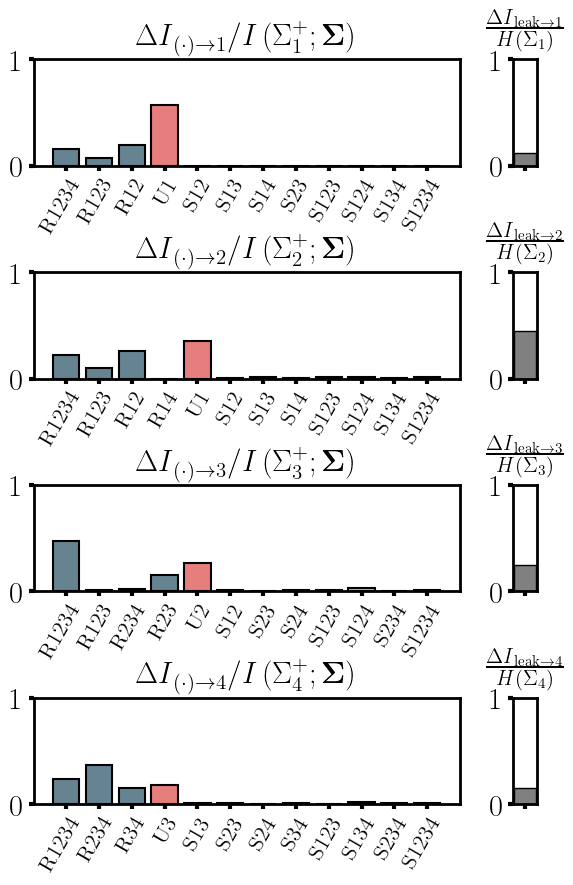

In [7]:
information_flux = {}

fig, axs = plt.subplots(nvars, 2, figsize=(10, 2.3*nvars), gridspec_kw={'width_ratios': [nvars*14, 1]})
plt.rcParams.update({'font.size': 18})

for i in range(nvars):
    I_R = I_R_results[i+1]
    I_S = I_S_results[i+1]
    MI = MI_results[i+1]
    info_leak = info_leak_results[i+1]

    information_flux[i+1] = surd.plot_nlabels(I_R, I_S, info_leak, axs[i,:], nvars, nlabels=12)

    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(\\Sigma_{i+1}^+ ; \\mathrm{{\\mathbf{{\\Sigma}}}} \\right)$',pad=10)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(\\Sigma_{i+1} \\right)}}$',pad=17)
    axs[i,1].set_yticks([0,1])
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=16, rotation = 60, ha = 'right', rotation_mode='anchor')

plt.tight_layout(w_pad=-15, h_pad=-0.1)
plt.show()

The most important causal contributions come from redundant and unique causalities, whereas synergistic causalities play a minor
role. The causal map for unique causalities (depicted in red) vividly captures the forward energy
cascade of causality toward smaller scales, which is inferred from the
non-zero terms $\Delta I^U_{1\rightarrow 2}$, $\Delta
I^U_{2\rightarrow 3}$, and $\Delta I^U_{3\rightarrow 4}$. Curiously, no unique causality is observed from smaller to larger scales,
and any backward causality arises solely through redundant causal
relationships. In the context of information-theoretic causality, this implies that no
new information is conveyed from the smaller scales to the larger
ones.